In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
%matplotlib inline

from datetime import time, date

# In this notebook, we'll explore the properties of the dataset, see which features have a lot of information, and try to see what feature engineering we can do

In [2]:
train = pd.read_csv('train.csv', parse_dates=[2,3])
test = pd.read_csv('test.csv', parse_dates=[2])

In [3]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

### First look indicates the data set is pretty simple; we've got: 
- times and locations of both pickups and dropoffs (dropoff time will not be provided for test data)
- number of passengers
- vendor/trip ID
- the variable store_and_fwd_flag. Per the dataset description, "This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip"
- The variable to be predicted is trip_duration, which is given in seconds. 
 
Latitude and longitude aren't easy to interpret. Since we're dealing with records for just New York City, we can transform them into cartesian coordinates. To minimize the distortion, let's put the origin at the center of the distribution. Then we can easily calculate the as-the-crow-flies distance traveled as well as the average speed (this can only be done for the training set, but can be used to identify bad data points).

In [4]:
R = 3959   #radius of earth in miles

def sind(x): return np.sin(np.pi * x/180)

def cosd(x): return np.cos(np.pi * x/180)

# This approximation, which assumes the curvature of the earth is zero,
# works as long as we don't have too large of an area. "Too large" means
# a sizeable fraction of the radius of the earth, so even for distances
# of 1,000 miles this should work fine (as long as we're not near a pole)

center_lat = np.mean(train['pickup_latitude'])
center_long = np.mean(train['pickup_longitude'])

train['px'] = R*(train['pickup_longitude'] - center_long)*np.pi/180*cosd(center_lat)
train['py'] = R*(train['pickup_latitude'] - center_lat)*np.pi/180
train['dx'] = R*(train['dropoff_longitude'] - center_long)*np.pi/180*cosd(center_lat)
train['dy'] = R*(train['dropoff_latitude'] - center_lat)*np.pi/180

train['crow_x'] = train['dx'] - train['px']
train['crow_y'] = train['dy'] - train['py']

train['crow_dist'] = np.sqrt((train['crow_x'])**2 + (train['crow_y'])**2)
train['crow_speed'] = train['crow_dist']/train['trip_duration']*3600

test['px'] = R*(test['pickup_longitude'] - center_long)*np.pi/180*cosd(center_lat)
test['py'] = R*(test['pickup_latitude'] - center_lat)*np.pi/180

test['dx'] = R*(test['dropoff_longitude'] - center_long)*np.pi/180*cosd(center_lat)
test['dy'] = R*(test['dropoff_latitude'] - center_lat)*np.pi/180

test['crow_x'] = test['dx'] - test['px']
test['crow_y'] = test['dy'] - test['py']

test['crow_dist'] = np.sqrt((test['crow_x'])**2 + (test['crow_y'])**2)

In [5]:
#def parse_date(datestr):
#    return datetime.strptime(datestr, '%Y-%m-%d %H:%M:%S')
#
#train['dt_pickup'] = np.vectorize(parse_date)(train['pickup_datetime'])
#train['dt_dropoff'] = np.vectorize(parse_date)(train['dropoff_datetime'])

In [6]:
msk = np.random.rand(len(train)) < 0.6
verify = train[~msk]
train = train[msk]

## Identifying bad data

Now that we have distances and speeds, we can check to see if there are any obviously unreasonable taxi trips in our dataset. Two obvious patterns come to mind: trip with an average speed excessively large, and extremely long trips that go only a short distance. First, let's see how many trips average over 75 mph, and remove them from the dataset

This section is counterproductive for maximizing Kaggle score, but would be best for creating a real-world model.

In [ ]:
print((train['crow_speed'] >= 75).sum())
outliers_fast = train[train['crow_speed'] >= 75]
train = train[train['crow_speed'] < 75]

We can look at the rows we've eliminated. Clearly something went wrong in the data entry process. The store_and_fwd_flag isn't set to Y on many of them, elminating malfunctions with that system as an obvious culprit. 

In [ ]:
outliers_fast

In [ ]:
train[train['crow_speed'] < 1].describe()

In [ ]:
train[train['crow_speed'] < 1].head(10)

In [ ]:
(train['crow_dist'] == 0).sum()

So we have almost 6,000 trips that don't move at all. It's not clear what's happening here -- perhaps a data recording error, or maybe people decide to not take the taxi after getting in. Though it's hard to see how such a non-trip would take over an hour, as we can see happens:

In [ ]:
train[train['crow_dist'] == 0].sort_values(by='trip_duration', ascending=False)[:5]

We can get rid of these as well, and we'll also get rid of very long slow trips (>1 hr, <1 mph)

In [ ]:
zero_dist_trips = train[train['crow_dist']==0]
train = train[train['crow_dist'] > 0]

long_slow_trips = train[train['crow_speed']/train['trip_duration']*3600 < 1]
train = train[train['crow_speed']/train['trip_duration']*3600 >= 1]

In [ ]:
train.sort_values(by='trip_duration', ascending=False)

Lots of the long trips end at exactly midnight. This is clearly a computer error of some kind. Let's see how many end at exactly midnight, and remove the ones over an hour long (real trips can obviously end at exactly midnight, so we don't want to get rid of all of them)

In [ ]:
trips_end_at_midnight_long = train[(train['dropoff_datetime'].dt.time == time(0,0,0)) & (train['trip_duration'] > 3600)]
train = train[~ train['id'].isin(trips_end_at_midnight_long['id'])]

In [ ]:
train.sort_values(by='trip_duration', ascending=False)[['id', 'crow_dist', 'crow_speed', 'trip_duration', 'pickup_datetime', 'dropoff_datetime']]

# Data Exploration

Now that we've thrown out all of the obvious outliers, it's time to look at the properties and distributions present in the data (thankfully this dataset, provided by Kaggle, has no missing data we have to deal with). Let's start with the most important variable, trip_duration

In [7]:
train['trip_duration'].describe()

count    8.760730e+05
mean     9.631470e+02
std      5.779905e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.630000e+02
75%      1.077000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

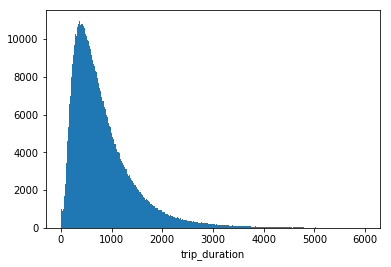

In [27]:
plt.hist(train['trip_duration'], bins=500, range=[0, 6000])
plt.xlabel('trip_duration')
plt.show()

This is clearly not normally distributed. In the contest description (specifically the scoring method), Kaggle gives us a hint that it's log-normally distributed. Let's see what the log of the trip duration looks like (the +1 is added so that RSME of the predictions of this variable will be the same as the Kaggle evaluation)

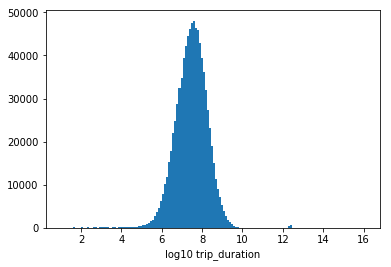

In [9]:
train['log_tripdur'] = np.log(train['trip_duration']) + 1
verify['log_tripdur'] = np.log(verify['trip_duration']) + 1
plt.hist(train['log_tripdur'], bins=150)
plt.xlabel('log10 trip_duration')
plt.show()

That at least looks Gaussian. To test, we'll turn to scipy.stats

In [10]:
stats.normaltest(train['log_tripdur'])

NormaltestResult(statistic=98187.28635476796, pvalue=0.0)

It's apparently not Gaussian. This test uses skewness and kurtosis; for a gaussian distribution they should be 0 and 3, respectively. Let's see what those values are for this:

In [11]:
print('skewness is: {:.4f}'.format(stats.skew(train['log_tripdur'])))
print('kurtosis is: {:.4f}'.format(stats.kurtosis(train['log_tripdur'])))

skewness is: -0.3338
kurtosis is: 4.1646


The negative skew is evident in the distribution as the longer tail on the left. The low kurtosis means that the tails are smaller than they would be for a gaussian distribution. This may affect the accuracy of the model we build, and is something we should study more.

But now, let's more on to examining the features. First, let's look at the variable store_and_fwd_flag. Let's see how the distribution of trip_duration (we'll always use log10 of trip duration now, unless otherwise stated) varies with the flag. First, the KS test, which reports the maximum difference between the cumulative histograms of the two datasets:

In [12]:
tripdur_store_true = train[train['store_and_fwd_flag']=='Y']['log_tripdur']
tripdur_store_false = train[train['store_and_fwd_flag']=='N']['log_tripdur']

In [13]:
tripdur_store_true.describe()

count    4896.000000
mean        7.631883
std         0.950229
min         1.693147
25%         7.109248
50%         7.701960
75%         8.245120
max        10.208739
Name: log_tripdur, dtype: float64

In [14]:
tripdur_store_false.describe()

count    871177.000000
mean          7.464573
std           0.798645
min           1.000000
25%           6.983936
50%           7.496775
75%           7.980076
max          16.075755
Name: log_tripdur, dtype: float64

These look pretty similar, though since only 8,000 out of 1.4 million have the flag active, it probably won't be able to add much to our model. To see if there's any information there at all, let's see if the KS test can differentiate between the two distributions:

In [15]:
stats.ks_2samp(tripdur_store_true, tripdur_store_false)

Ks_2sampResult(statistic=0.12419302228498152, pvalue=7.050446968368035e-66)

So clearly there is a difference. We'll see later if it affects the model.

# Feature Engineering

We've already done a some feature engineering by turning the latitudes/longitudes into cartesian coordinates, finding the distance, and taking the log of the trip duration. But there's more we can do.

The first thing is to remember that taxis don't get to travel as the crow flies. Instead, they're bound to city streets. What we'd really like is to know how far the taxi had to travel, and maybe even which streets it traveled down, but that's for another, much larger project. But because these trips happen in Manhattan, and the streets of Manhattan form a grid, we can get a pretty good approximation of distance traveled. Per [this webpage](http://www.charlespetzold.com/etc/AvenuesOfManhattan/index.html), the streets are about 29 degrees off of a north/south and east/west grid. With that knowledge, we can find the "Manhattan distance", essentially using a rotation matrix.

In [16]:
train['manhattan_x'] = train['crow_x']*cosd(29) - train['crow_y']*sind(29)
train['manhattan_y'] = train['crow_x']*sind(29) + train['crow_y']*cosd(29)
train['manhattan_dist'] = train['manhattan_x'] + train['manhattan_y']

verify['manhattan_x'] = verify['crow_x']*cosd(29) - verify['crow_y']*sind(29)
verify['manhattan_y'] = verify['crow_x']*sind(29) + verify['crow_y']*cosd(29)
verify['manhattan_dist'] = verify['manhattan_x'] + verify['manhattan_y']

test['manhattan_x'] = test['crow_x']*cosd(29) - test['crow_y']*sind(29)
test['manhattan_y'] = test['crow_x']*sind(29) + test['crow_y']*cosd(29)
test['manhattan_dist'] = test['manhattan_x'] + test['manhattan_y']

The final piece of feature engineering we'll do before introducing more data is to extract as much information out of the pickup time as we can. Instead of a single date/timestamp, we'll split it up into month, day, hour, minute, and second (all occur in 2016; thus the year is discarded). It's doubtful that the precise second will have any meaning, but we'll see. We also want day of the week (numbered, Monday is 0), and a counter of number of days since the start. We'll also add a bit showing if it's a weekend or a weekday.

In [17]:
train['month'] = train['pickup_datetime'].dt.month
train['day'] = train['pickup_datetime'].dt.day
train['day_counter'] = (train['pickup_datetime'].dt.date - date(2016, 1, 1)).dt.days
train['dow'] = (train['day_counter']-4) % 7
train['hour'] = train['pickup_datetime'].dt.hour
train['minute'] = train['pickup_datetime'].dt.minute
train['is_weekday'] = train['dow']<5

verify['month'] = verify['pickup_datetime'].dt.month
verify['day'] = verify['pickup_datetime'].dt.day
verify['day_counter'] = (verify['pickup_datetime'].dt.date - date(2016, 1, 1)).dt.days
verify['dow'] = (verify['day_counter']-4) % 7
verify['hour'] = verify['pickup_datetime'].dt.hour
verify['minute'] = verify['pickup_datetime'].dt.minute
verify['is_weekday'] = verify['dow']<5

test['month'] = test['pickup_datetime'].dt.month
test['day'] = test['pickup_datetime'].dt.day
test['day_counter'] = (test['pickup_datetime'].dt.date - date(2016, 1, 1)).dt.days
test['dow'] = (test['day_counter']-4) % 7
test['hour'] = test['pickup_datetime'].dt.hour
test['minute'] = test['pickup_datetime'].dt.minute
test['is_weekday'] = test['dow']<5

In [18]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'px', 'py', 'dx', 'dy', 'crow_x', 'crow_y',
       'crow_dist', 'crow_speed', 'log_tripdur', 'manhattan_x', 'manhattan_y',
       'manhattan_dist', 'month', 'day', 'day_counter', 'dow', 'hour',
       'minute', 'is_weekday'],
      dtype='object')

Now we should see if there are any columns that we should throw out completely. The latitude/longitude are nearly completely redundant, but they may be useful if we gather other data with known locations. The only column we'll throw away now is crow_speed. It was used solely to help evaluate bad data points, and can't be used for the model since we won't be able to calculate it for the test data. 

In [19]:
train = train[[col for col in train.columns if col not in ['crow_speed']]]
verify = verify[[col for col in verify.columns if col not in ['crow_speed']]]

# Adding Weather Data

With another script, I've scraped weather data from wunderground.com for NYC. Here, we'll add that information to the data tables. Thanks to some pandas magic, this is really fast and easy.

In [59]:
weather = pd.read_csv('weatherdata.csv')
weather['timestamp'] = pd.to_datetime(weather['timestamp'])
weather = weather.sort_values(by='timestamp')

train_sorted = train.sort_values(by='pickup_datetime')
verify_sorted = verify.sort_values(by='pickup_datetime')
test_sorted = test.sort_values(by='pickup_datetime')

In [60]:
train = pd.merge_asof(train_sorted, weather, left_on='pickup_datetime', right_on='timestamp', 
                      tolerance=pd.Timedelta(1, 'h'), direction='nearest')
verify = pd.merge_asof(verify_sorted, weather, left_on='pickup_datetime', right_on='timestamp', 
                       tolerance=pd.Timedelta(1, 'h'), direction='nearest')
test = pd.merge_asof(test_sorted, weather, left_on='pickup_datetime', right_on='timestamp', 
                     tolerance=pd.Timedelta(1, 'h'), direction='nearest')

In [62]:
train.to_csv('train_cleaned.csv', index=False)
verify.to_csv('verify_cleaned.csv', index=False)
test.to_csv('test_cleaned.csv', index=False)

In [63]:
train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,windspeed,humidity,precip,pressure,conditions,dailyprecip,dailysnow,fog,rain,snow
0,id1665586,1,2016-01-01 00:00:53,2016-01-01 00:22:27,1,-73.985085,40.747166,-73.958038,40.717491,N,...,4.6,51.0,0.0,30.06,Overcast,0.0,0.0,0.0,0.0,0.0
1,id1210365,2,2016-01-01 00:01:01,2016-01-01 00:07:49,5,-73.965279,40.801041,-73.947479,40.815170,N,...,4.6,51.0,0.0,30.06,Overcast,0.0,0.0,0.0,0.0,0.0
2,id3888279,1,2016-01-01 00:01:14,2016-01-01 00:05:54,1,-73.982292,40.751331,-73.991341,40.750340,N,...,4.6,51.0,0.0,30.06,Overcast,0.0,0.0,0.0,0.0,0.0
3,id0924227,1,2016-01-01 00:01:20,2016-01-01 00:13:36,1,-73.970108,40.759800,-73.989357,40.742989,N,...,4.6,51.0,0.0,30.06,Overcast,0.0,0.0,0.0,0.0,0.0
4,id2294362,2,2016-01-01 00:01:33,2016-01-01 00:13:25,1,-73.984993,40.773891,-73.936493,40.847771,N,...,4.6,51.0,0.0,30.06,Overcast,0.0,0.0,0.0,0.0,0.0
5,id1078247,2,2016-01-01 00:01:37,2016-01-01 00:03:31,1,-73.973335,40.764072,-73.974854,40.761734,N,...,4.6,51.0,0.0,30.06,Overcast,0.0,0.0,0.0,0.0,0.0
6,id0566105,2,2016-01-01 00:03:31,2016-01-01 00:26:35,1,-74.006439,40.739475,-73.967201,40.769188,N,...,4.6,51.0,0.0,30.06,Overcast,0.0,0.0,0.0,0.0,0.0
7,id0372520,1,2016-01-01 00:03:35,2016-01-01 00:16:25,1,-73.969788,40.757584,-73.951576,40.759445,N,...,4.6,51.0,0.0,30.06,Overcast,0.0,0.0,0.0,0.0,0.0
8,id2563820,2,2016-01-01 00:05:07,2016-01-01 00:09:54,1,-73.959511,40.762810,-73.968391,40.770519,N,...,4.6,51.0,0.0,30.06,Overcast,0.0,0.0,0.0,0.0,0.0
9,id0400882,2,2016-01-01 00:05:08,2016-01-01 00:23:01,1,-73.962738,40.775566,-73.927994,40.864761,N,...,4.6,51.0,0.0,30.06,Overcast,0.0,0.0,0.0,0.0,0.0
